In [86]:
import shap
from shap._explanation import Cohorts
import pickle
import numpy as np
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order, calc_instance_order, plot_2d, \
                       plot_feature_importance_bar, plot_feature_importance_scatter, plot_feature_effects, plot_forces, \
                       ensure_shap_values_are_3d
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.cm as cm
shap.initjs()
%matplotlib inline
task_name = '08'

In [87]:
with open(task_name + '.dataset', 'rb') as f:
    X, y, feature_names = pickle.load(f)
with open(task_name + '.models', 'rb') as f:
    comparer = pickle.load(f)
with open(task_name + '.expl', 'rb') as f:
    explanations, _, _ = pickle.load(f)

# Local Explanations

Here we will use the explanations obtained globally for the multiclass difference classifier to cluster instances, and inspect the individual classifiers explanations on a local level for selected clusters.

In [88]:
is_pred_diff = comparer.predict_bin_diff(explanations.data)
explanations_diff = explanations[is_pred_diff]

## Supervised Clustering of Instances by their Explanations

We fit a regression tree on the original features to predict the difference class SHAP values of the multiclass difference classifier. Instances are weighted by their probability of the classifiers predicting differently, in order for it to focus on the interesting regions.

In [110]:
n_clusters = 11
cluster_names = np.array([f'c{i+1}' for i in range(n_clusters)])
shap_values = explanations.mclass_diff.labels[:, :, comparer.difference_class_names]
shap_values = ensure_shap_values_are_3d(shap_values)
values = shap_values.values.reshape(
        (shap_values.values.shape[0],
         shap_values.values.shape[1] * shap_values.values.shape[2]))
tree = DecisionTreeRegressor(max_leaf_nodes=n_clusters)
diff_proba = comparer.predict_bin_diff_proba(shap_values.data)
tree.fit(shap_values.data, values, sample_weight=diff_proba)

DecisionTreeRegressor(max_leaf_nodes=11)

Now, let's see what the tree looks like. For each leaf, the cluster number is included and the number of instances in each class of the multiclass difference classifier.

In [123]:
leaf_node_ids = np.where(tree.tree_.children_left == -1)[0]
def predict_clusters(X):
    node_ids = tree.apply(X)
    return np.searchsorted(leaf_node_ids, node_ids)
cluster_numbers  = predict_clusters(explanations.data)

In [124]:
occurences = np.zeros((leaf_node_ids.shape[0], comparer.classes.shape[0]), dtype=int)
mclass_diff = comparer.predict_mclass_diff(X)
for class_idx in comparer.classes:
    indices, counts = np.unique(cluster_numbers[mclass_diff == class_idx], return_counts=True)
    occurences[indices, class_idx] = counts
occurences = pd.DataFrame(occurences, index=leaf_node_ids, columns=comparer.class_names)

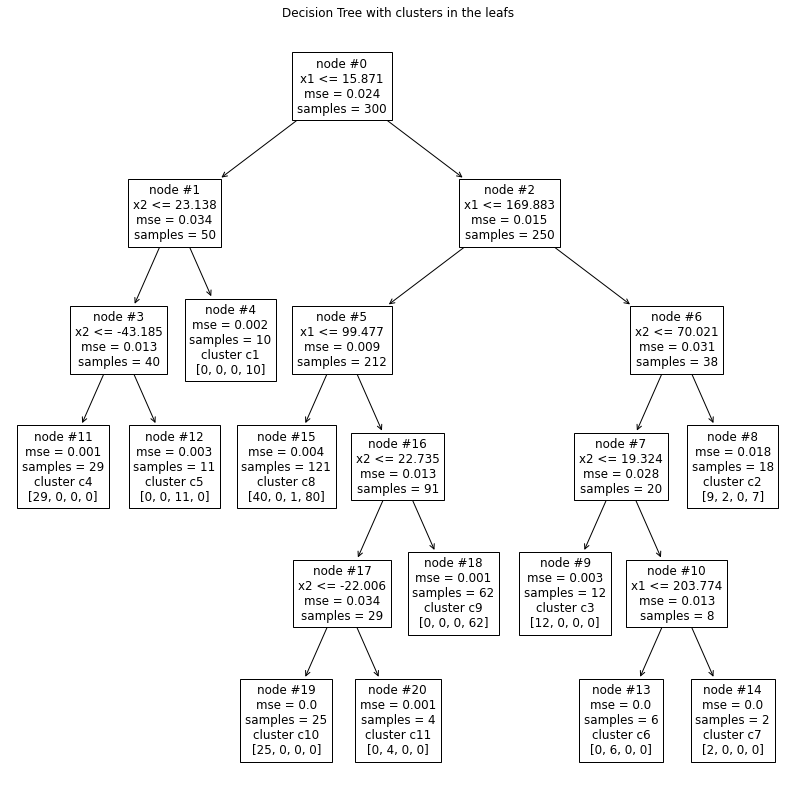

In [125]:
fig, ax = plt.subplots(figsize=(14, 14))
annotations = plot_tree(tree, ax=ax, feature_names=feature_names, node_ids=True)
for annotation in annotations:
    text = annotation.get_text()
    node_idx = int(text[text.find('#')+1:text.find('\n')])
    text = text[:text.find('\nvalue =')]
    if node_idx in leaf_node_ids:
        leaf_idx = np.where(occurences.index == node_idx)[0][0]
        text = text + f'\ncluster {cluster_names[leaf_idx]}'
        text = text + f'\n{occurences.loc[node_idx, :].to_list()}'
    annotation.set_text(text)
ax.set_title('Decision Tree with clusters in the leafs')
plt.show()

In [126]:
print(comparer.class_names)

['(0, 0)' '(0, 1)' '(1, 0)' '(1, 1)']


In the decision boundary plot we see, that most of the instances with different predictions are in three clusters, while three instances remain in others:

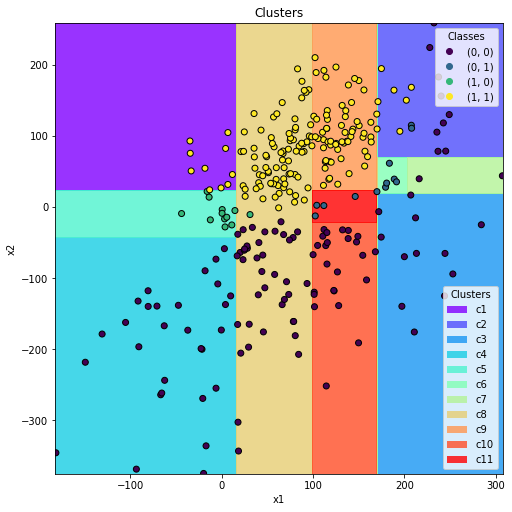

In [127]:
idx_x, idx_y = 0, 1
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True)
x_min, x_max = explanations.data[:, idx_x].min() - .5, explanations.data[:, idx_x].max() + .5
y_min, y_max = explanations.data[:, idx_y].min() - .5, explanations.data[:, idx_y].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.5), np.arange(y_min, y_max, 0.5))
z_pred = predict_clusters(np.c_[xx.ravel(), yy.ravel()])
z_pred = z_pred.reshape(xx.shape)
plt_colors = cm.rainbow(np.linspace(0, 1, n_clusters))
levels = np.arange(n_clusters + 1)
contour = ax.contourf(xx, yy, z_pred + 0.5, levels, colors=plt_colors, alpha=.8)
scatter = ax.scatter(explanations.data[:, idx_x], explanations.data[:, idx_y], c=mclass_diff, edgecolors='k')
ax.set_xlabel(feature_names[idx_x])
ax.set_ylabel(feature_names[idx_y])
ax.set_title('Clusters')
class_legend = plt.legend(scatter.legend_elements()[0], comparer.class_names, title='Classes', loc='upper right')
plt.gca().add_artist(class_legend)
plt.legend(contour.legend_elements()[0], cluster_names, title='Clusters', loc='lower right');

Now that we have obtained a global clustering, we extract all relevant clusters with a share of at least 50% of instances with different predictions:

In [128]:
threshold_pct = 0.5
diff_occurences = occurences.iloc[:, comparer.difference_classes].sum(axis=1)
equal_occurences = occurences.iloc[:, comparer.equality_classes].sum(axis=1)
clusters_diff_indices = np.where(diff_occurences / equal_occurences > threshold_pct)[0]
clusters_diff = Cohorts(**dict([(k, v) for k, v in cohorts.cohorts.items() if int(k) in clusters_diff_indices]))

In [136]:
mask = np.apply_along_axis(lambda a: np.isin(a, clusters_diff_indices), 0, cluster_numbers)
explanations_clustered = explanations[mask]
diff_cluster_numbers = predict_clusters(explanations_clustered.data)
explanations_clustered = explanations_clustered.cohorts(cluster_names[diff_cluster_numbers])

### Feature Influence

Obtain a feature order, ranked by mean absolute influence on the instances with different predictions:

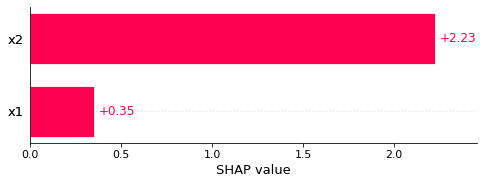

In [134]:
feature_order, feature_importance = calc_feature_order(explanations.bin_diff.log_odds[is_pred_diff])
plot_feature_importance_bar(feature_importance)

When comparing the mean influence per feature of each cluster, we notice that the influence of x1, which does have a lower influence overall on the predictions being different, has influence on what difference class is most present in a cluster (negative influences).

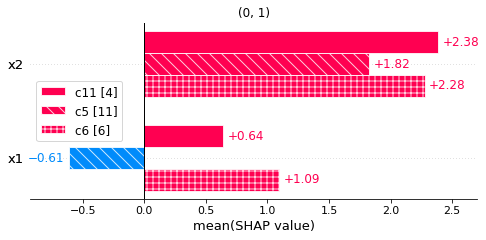

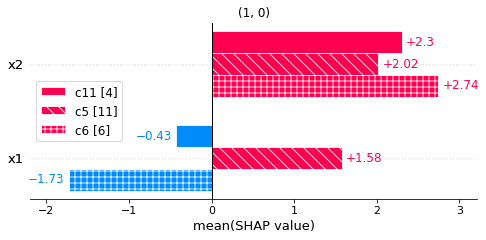

In [135]:
for label in comparer.difference_class_names:
    plt.title(label)
    shap.plots.bar(explanations_clustered.mclass_diff.log_odds[:, :, label].mean(0))

### Feature Effects

Looking at the marginal effects of the two features on the outcome we can confirm, that the differences of the effects of x1 are bigger than those of x2 and that it is of a different shape for cluster c5 vs. c11 and c6.

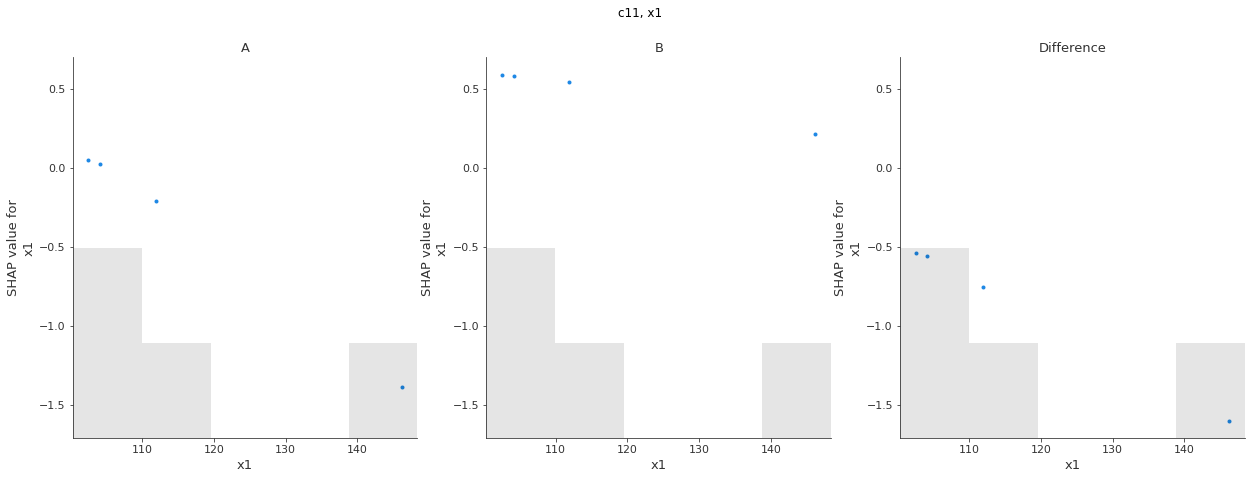

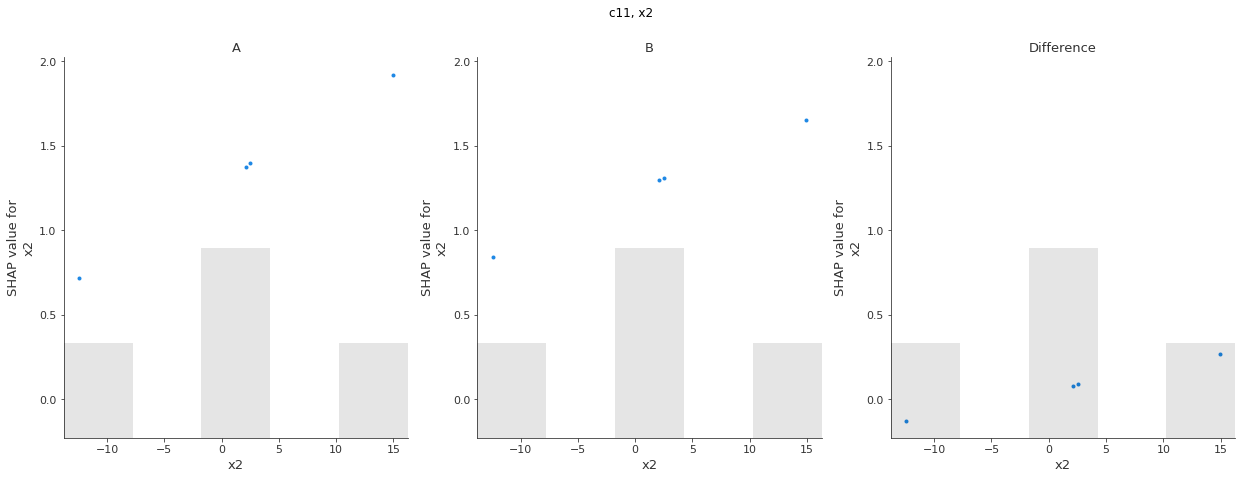

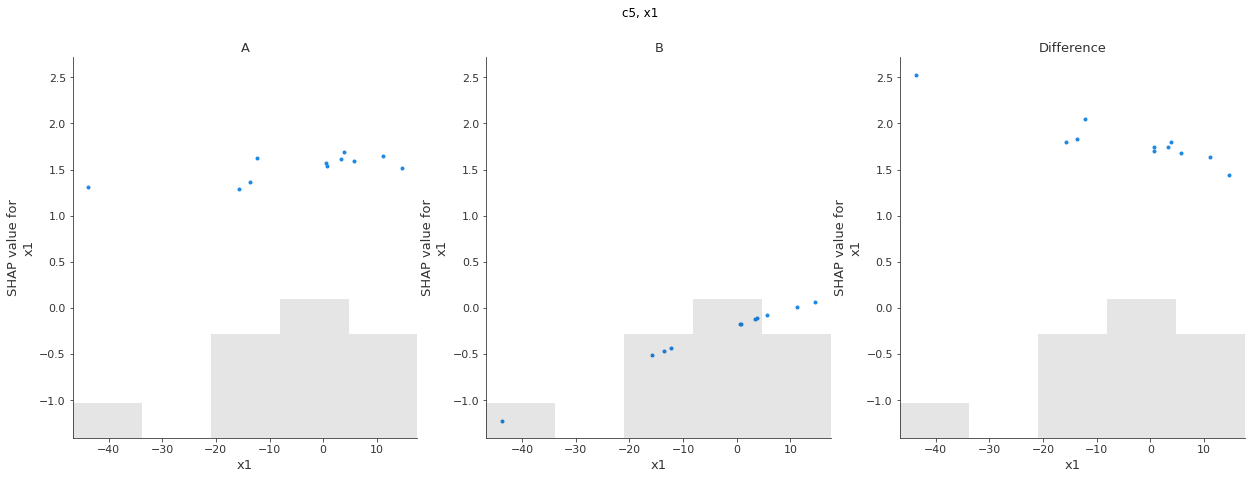

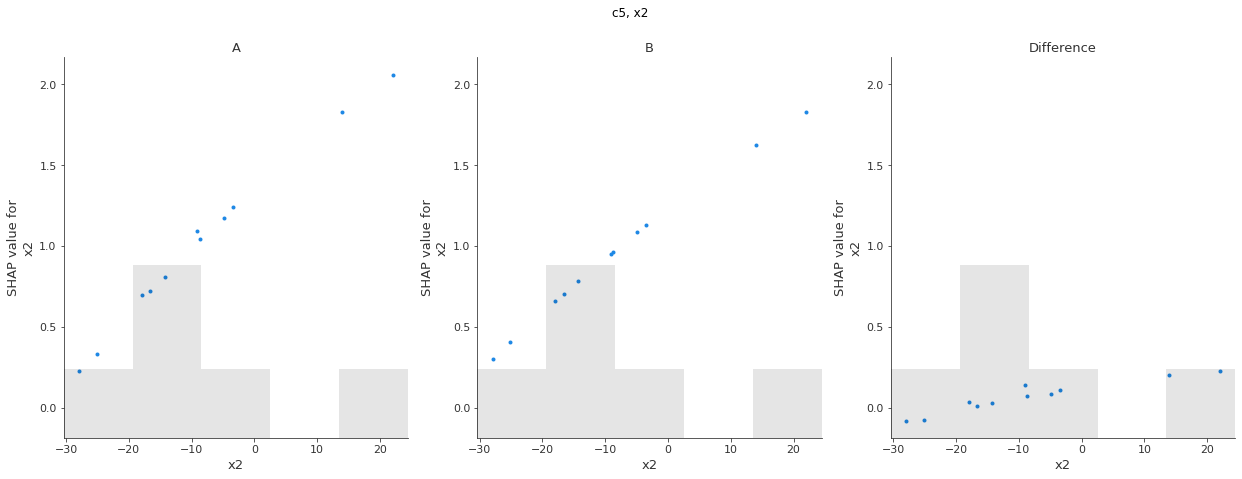

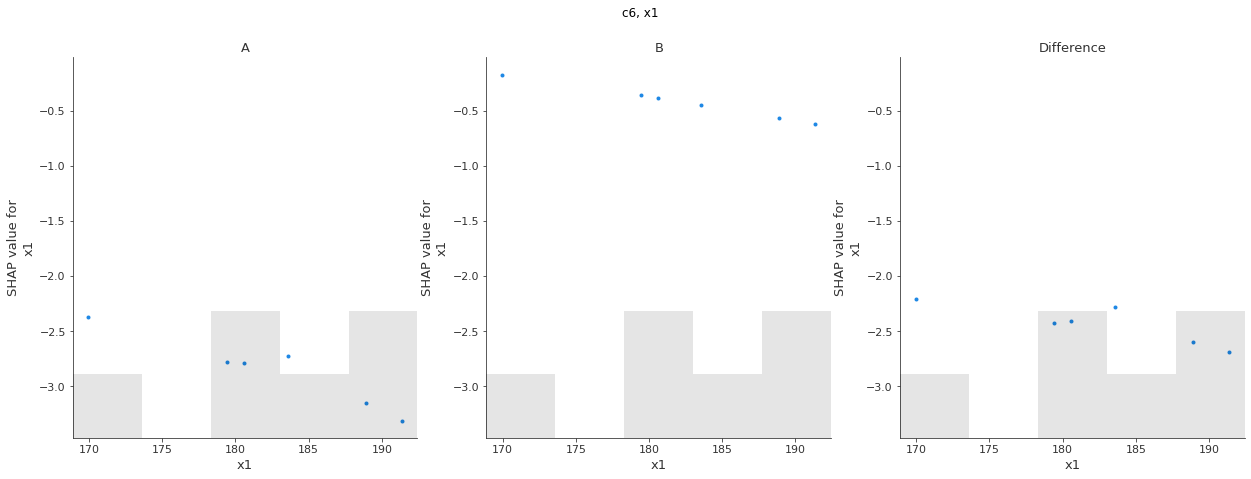

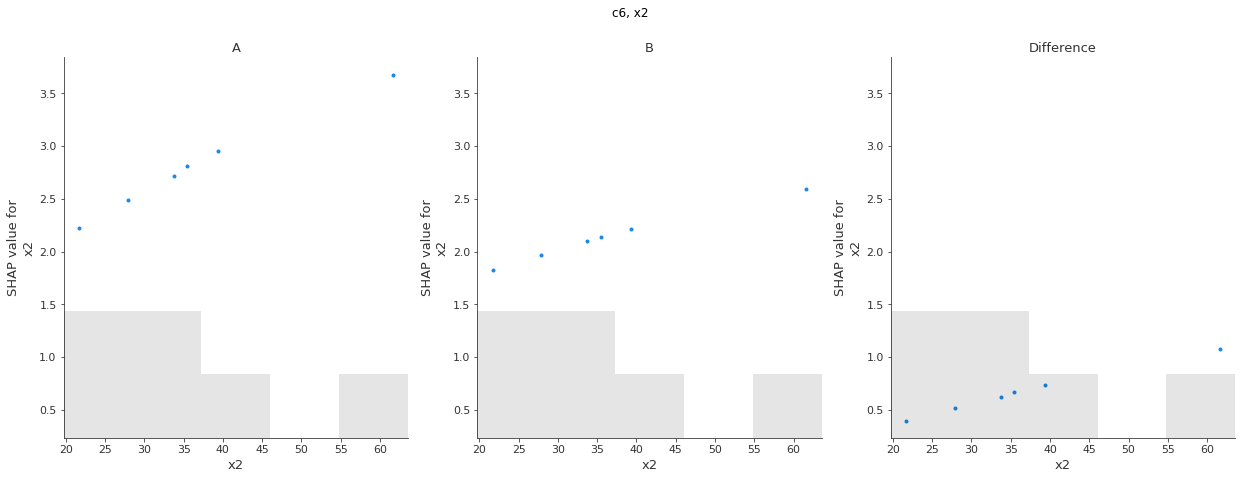

In [147]:
indiv = explanations_clustered.indiv.log_odds[:, :, 1]
diff = explanations_clustered.indiv_diff.log_odds[:, :, 1]
for (cluster_name, shap_values_a), shap_values_b, shap_values_diff in \
    zip(indiv.A.cohorts.items(), indiv.B.cohorts.values(), diff.cohorts.values()):
        for feature in feature_names:
            fig, axs = plt.subplots(ncols=3, figsize=(21, 7), sharex=True, sharey=True)
            shap.plots.scatter(shap_values_a[:, feature], ax=axs[0], title='A', show=False)
            shap.plots.scatter(shap_values_b[:, feature], ax=axs[1], title='B', show=False)
            shap.plots.scatter(shap_values_diff[:, feature], ax=axs[2], title='Difference', show=False)
            fig.suptitle(f'{cluster_name}, {feature}')
            plt.show()

### Decision Plot

We see quite different decision paths for the two clusters when comparing those of A and B. They are similar for x2, but with x1 they either go over 0.5 or under.

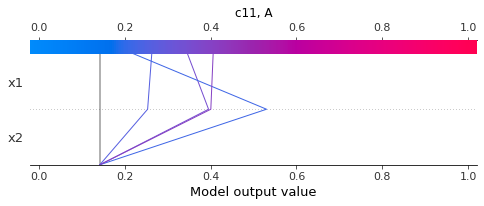

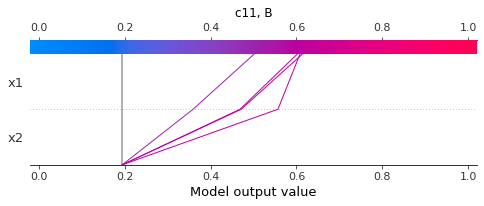

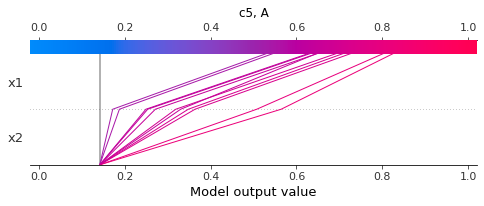

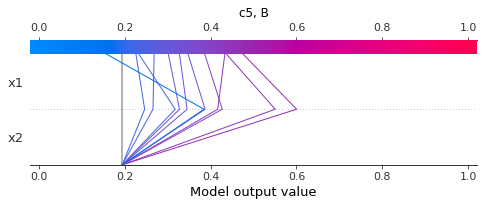

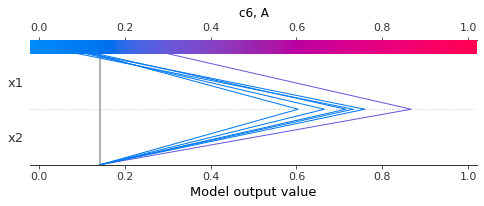

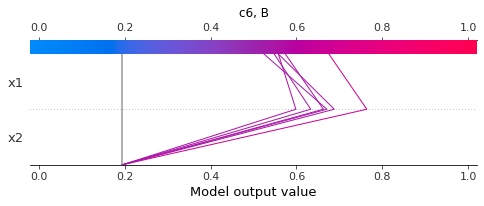

In [150]:
indiv = explanations_clustered.indiv.log_odds[:, :, 1]
for cluster_name in ns.A.cohorts.keys():
    for clf_name, shap_values in [('A', indiv.A), ('B', indiv.B)]:
        shap_values = shap_values.cohorts[cluster_name]
        shap.decision_plot(shap_values.base_values[0], shap_values.values, features=shap_values.data,
                           feature_names=shap_values.feature_names, feature_order=feature_order,
                           link='logit', title=f'{cluster_name}, {clf_name}')

### Force Plot

Furthermore we visualize the instances in force plots, ordered by similarity of their multiclass difference classes.

In [154]:
indiv = explanations_clustered.indiv.log_odds[:, :, 1]
for cluster_name in indiv.A.cohorts.keys():
    instance_order = calc_instance_order(
        explanations_clustered.mclass_diff.log_odds[
            :,
            :,
            comparer.difference_class_names
        ].cohorts[cluster_name])
    for clf_name, shap_values in [('A', indiv.A), ('B', indiv.B)]:
        shap_values = shap_values.cohorts[cluster_name]
        plot = shap.plots.force(
            base_value=shap_values.base_values[0],
            shap_values=shap_values.values,
            features=shap_values.data,
            feature_names=shap_values.feature_names,
            out_names=f'{cluster_name}, {clf_name}',
            ordering_keys=instance_order.tolist(),
            link='logit')
        display(plot)